### R2U-Net

Task: Implement R2U-Net model from the paper https://arxiv.org/abs/1802.06955 <br/>

Metrics for evaluation: Accuracy, sensitivity, specificity, f1-score, Dice-coefficient, Jaccard Similarity, AUC and ROC curve. <br/>

$$Acc = \frac{TP+TN}{TP+TN+FP+FN}$$
$$SE = \frac{TP}{TP+FN}$$
$$SP = \frac{TN}{TN+FP}$$
$$DC = \frac{|GT \cap SR|}{|GT| + |SR|}$$
$$JS = \frac{|GT \cap SR|}{|GT \cup SR|}$$

In [14]:
#!pip install scipy==1.1.0

In [15]:
# Imports
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import glob
import torch.nn as nn
import torchvision

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
from torchvision.datasets import Cityscapes
import torch.nn as nn

In [16]:
# cityscapes Dataloader: https://github.com/Tramac/awesome-semantic-segmentation-pytorch/blob/master/core/data/dataloader/cityscapes.py
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py

In [17]:
#!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=s8awdesh&password=OfficialNLP*&submit=Login' https://www.cityscapes-dataset.com/login/

# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3 # => leftImg8bit
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1 #=> gtFine

# !unzip gtFine_trainvaltest.zip
# !unzip leftImg8bit_trainvaltest.zip

In [18]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.backends.cudnn.benchmark = False

import warnings
warnings.filterwarnings('ignore')

### 1.1 Load the dataset

In [19]:
def recursive_glob(rootdir=".", suffix=""):
    """Performs recursive glob with given suffix and rootdir
    :param rootdir is the root directory
    :param suffix is the suffix to be searched
    """
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]

class cityscapesLoader(data.Dataset):
    """
    cityscapesLoader
    https://www.cityscapes-dataset.com
    Data is derived from CityScapes, and can be downloaded from here:
    https://www.cityscapes-dataset.com/downloads/
    Many Thanks to @fvisin for the loader repo:
    https://github.com/fvisin/dataset_loaders/blob/master/dataset_loaders/images/cityscapes.py
    """
    
    colors = [
        #[0,   0,   0], 
        [128, 64, 128], [244, 35, 232], [70, 70, 70],
        [102, 102, 156], [190, 153, 153], [153, 153, 153], [250, 170, 30],
        [220, 220, 0], [107, 142, 35], [152, 251, 152], [0, 130, 180],
        [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
        [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32],
    ]
    
    label_colours = dict(zip(range(19), colors))
    mean_rgb = {
        "pascal": [103.939, 116.779, 123.68],
        "cityscapes": [0.0, 0.0, 0.0],
    }  # pascal mean for PSPNet and ICNet pre-trained model
    
    def __init__(
        self,
        root,
        split="train",
        is_transform=False,
        img_size=(512, 1024),
        augmentations=None,
        img_norm=True,
        version="cityscapes",
        test_mode=False,
    ):
        """__init__
        :param root:
        :param split:
        :param is_transform:
        :param img_size:
        :param augmentations
        """
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array(self.mean_rgb[version])
        self.files = {}
        
        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")
        
        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25,
                              26, 27, 28, 31, 32, 33,]
        
        self.class_names = [#"unlabelled", 
                            "road", "sidewalk", "building",
                            "wall", "fence", "pole", "traffic_light",
                            "traffic_sign", "vegetation", "terrain", "sky",
                            "person", "rider", "car", "truck", "bus",
                            "train", "motorcycle", "bicycle"
                           ]
        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_classes, range(19)))
        
        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))
        
        print("Found %d %s images" % (len(self.files[split]), split))
    
    def __len__(self):
        return len(self.files[self.split])+0
    
    def __getitem__(self, index):
        """__getitem__
        :param index:
        """
        img_path = self.files[self.split][index].rstrip()
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )
        
        img = m.imread(img_path)
        img = np.array(img, dtype=np.uint8)
        
        lbl = m.imread(lbl_path)
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))
        
        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)
        
        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        
        return img, lbl
    
    def transform(self, img, lbl):
        """transform
        :param img:
        :param lbl:
        """
        img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)
        
        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
        lbl = lbl.astype(int)
        
        if not np.all(classes == np.unique(lbl)):
            print("WARN: resizing labels yielded fewer classes")
        
        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")
        
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        
        return img, lbl
    
    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]
        
        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        
        return rgb

    def encode_segmap(self, mask):
        # Put all void classes to zero
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

### 1.2 Define model architecture

In [20]:
# Define up convolution block
def up_conv(in_c, out_c):
    upconv = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return upconv

# Define recurrent block
class rec_block(nn.Module):
    def __init__(self, out_c, t):
        super(rec_block, self).__init__()
        self.t = t
        self.out_c = out_c
        
        self.rec_conv = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, image):
        for i in range(self.t):
            if i == 0:
                x1 = self.rec_conv(image)
            x1 = self.rec_conv(image+x1)
        return x1

# Define recurrent residual block
class rr_block(nn.Module):
    def __init__(self, in_c, out_c, t=2):
        super(rr_block, self).__init__()
        self.rcnn = nn.Sequential(
            rec_block(out_c, t=t),
            rec_block(out_c, t=t)
        )
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0)
    
    def forward(self, image):
        x1 = self.conv(image)
        x2 = self.rcnn(x1)
        out = x1+x2
        return out

# R2U-Net Architecture
class R2UNet(nn.Module):
    #img_ch=3, output_ch=1, t=2
    def __init__(self):
        super(R2UNet, self).__init__()
        filters = [64, 128, 256, 512, 1024]
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)
        
        self.RR_block1 = rr_block(3, filters[0], t=2)
        self.RR_block2 = rr_block(filters[0], filters[1], t=2)
        self.RR_block3 = rr_block(filters[1], filters[2], t=2)
        self.RR_block4 = rr_block(filters[2], filters[3], t=2)
        self.RR_block5 = rr_block(filters[3], filters[4], t=2)
        
        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_rr_block5 = rr_block(filters[4], filters[3], t=2)
        
        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_rr_block4 = rr_block(filters[3], filters[2], t=2)
        
        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_rr_block3 = rr_block(filters[2], filters[1], t=2)
        
        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_rr_block2 = rr_block(filters[1], filters[0], t=2)
        
        self.Conv = nn.Conv2d(filters[0], 1, kernel_size=1, stride=1, padding=0)
        
    def forward(self, image): 
        #encoding path
        x1 = self.RR_block1(image)
        
        x2 = self.Maxpool(x1)
        x2 = self.RR_block2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RR_block3(x3)
        
        x4 = self.Maxpool(x3)
        x4 = self.RR_block4(x4)
        
        x5 = self.Maxpool(x4)
        x5 = self.RR_block5(x5)
        
        #decoding path
        y5 = self.Up5(x5)
        y5 = torch.cat((x4, y5), dim=1)
        y5 = self.Up_rr_block5(y5)
        
        y4 = self.Up4(y5)
        y4 = torch.cat((x3, y4), dim=1)
        y4 = self.Up_rr_block4(y4)
        
        y3 = self.Up3(y4)
        y3 = torch.cat((x2, y3), dim=1)
        y3 = self.Up_rr_block3(y3)
        
        y2 = self.Up2(y3)
        y2 = torch.cat((x1, y2), dim=1)
        y2 = self.Up_rr_block2(y2)
        out = self.Conv(y2)
        
        print(out.shape)
        
        return out

### 1.3 Hyperparameters

In [21]:
local_path = "./"
#dst = cityscapesLoader(root=local_path)
epochs = 2
bs = 2

### 1.4 Dataset and Dataloader

In [22]:
# dataset variable
# augs = aug.Compose([aug.RandomRotate(10), aug.RandomHorizontallyFlip()])

traindataset = cityscapesLoader(root=local_path, is_transform=True, split='train')
validdataset = cityscapesLoader(root=local_path, is_transform=True, split='val')
# dataloader variable
trainloader = data.DataLoader(traindataset, batch_size=bs, shuffle=True)
validloader = data.DataLoader(validdataset, batch_size=bs, shuffle=False)

Found 2975 train images
Found 500 val images
Found 2975 train images
Found 500 val images


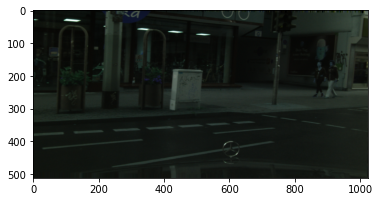

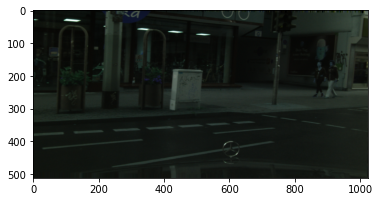

In [23]:
## Just added this cell for visualization of 3 images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.3, 0.3, 0.3])
    #std = np.array([0.4, 0.1, 0.2])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

it = iter(trainloader)
images, labels = next(it)
out = torchvision.utils.make_grid(images)
imshow(out)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

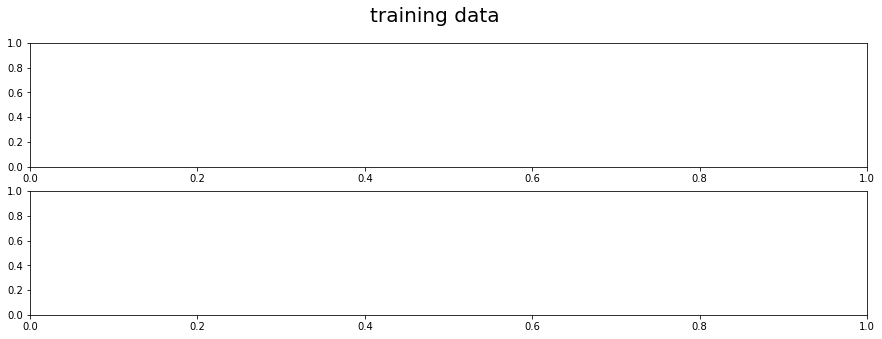

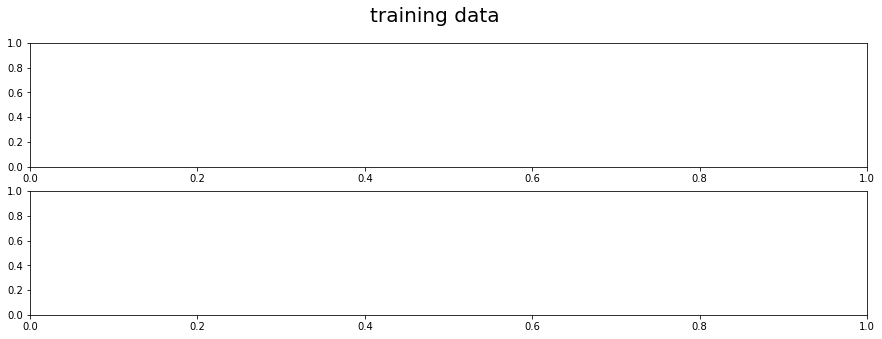

In [24]:
# Batch-wise visualisation

# i, d in enumerate(trainloader) ---> here, d is list
# img--d[0] has the shape [2,3,512,512] or [batch_sz, #img_channels, img_sz, img_sz] -- img batch
# label--d[1] has the shape [2, 512, 512] or [batch_sz, mask_sz, mask_sz] -- mask batch
# Verifying training and validation data
def visualize_data(batch_sz, loader, dataset_var, data_title):
    dst = dataset_var
    for i, data in enumerate(loader):
        # increase the count if u want to visualize more batches
        if i>0:
            break
        imgs, labels = data
        imgs = imgs.numpy()
        imgs = np.transpose(imgs, [0,2,3,1])

        fig, axes = plt.subplots(nrows = 2, ncols = batch_sz, figsize=(15,5))
        fig.suptitle(data_title, fontsize=20)
        for j in range(0, batch_sz):
            I = imgs[j]
            axes[0,j].imshow(np.clip(I, 0, 1))
            axes[1,j].imshow(dst.decode_segmap(labels.numpy()[j]))
        plt.title('hi')
        plt.show()

visualize_data(bs, trainloader, traindataset, 'training data')
visualize_data(bs, validloader, validdataset, 'validation data')

### 1.5 Loss function and optimiser

In [25]:
model = R2UNet()

In [26]:
# loss function
loss_f = nn.CrossEntropyLoss()

# optimizer variable
# opt = torch.optim.SGD(model.parameters(), weight_decay=5*1e-4, lr = 0.0001, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

### 1.6 Training

In [27]:
def save_checkpoint(state, filename="task2_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])

In [28]:
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"

def evaluate(dataset, data_loader, model, epoch):
    # put model in eval mode
    model.eval()
    # init final_loss to 0
    final_loss = 0
    # calculate number of batches and init tqdm
    num_batches = int(len(dataset) / data_loader.batch_size)
    tk0 = tqdm(data_loader, total=num_batches)
    # we need no_grad context of torch. this save memory
    with torch.no_grad():
        for inputs, targets in tk0:
            tk0.set_description(f"Validation Epoch {epoch+1}")
            inputs = inputs.to(DEVICE, dtype=torch.float)
            targets = targets.to(DEVICE, dtype=torch.long)
            output = model(inputs)
            loss = criterion(output, targets)
            # add loss to final loss
            final_loss += loss
            tk0.set_postfix(loss = (final_loss / num_batches).item())
    # close tqdm
    tk0.close()
    # return average loss over all batches
    return final_loss / num_batches

def train(traindataset, validdataset, trainloader, validloader, model, criterion, optimizer, epochs, Load_Model=False):
    """
    training function that trains for one epoch
    :param dataset: dataset class (SIIMDataset)
    :param data_loader: torch dataset loader
    :param model: model
    :param criterion: loss function
    :param optimizer: adam, sgd, etc.
    """
    
    if torch.cuda.is_available():
        criterion = criterion.cuda()
    
    train_loss = []
    valid_loss = []
    model_weights = []
    valid_loss_min = np.Inf
    
    if Load_Model:
        load_checkpoint("task2_checkpoint.pth.tar", model)
    
    for epoch in range (epochs):
        model.train()
        
        with tqdm(trainloader, unit="batch") as tk0:
            for inputs, targets in tk0:
                tk0.set_description(f"Epoch {epoch+1}")
                # fetch input images and masks from dataset batch
                # move images and masks to cpu/gpu device
                inputs = inputs.to(DEVICE, dtype=torch.float)
                targets = targets.to(DEVICE, dtype=torch.long)
                
                # zero grad the optimizer
                optimizer.zero_grad()
                # forward step of model
                outputs = torch.max(model(inputs))
                # calculate loss
                loss = criterion(outputs, targets)
                loss.backward()
                # step the optimizer
                optimizer.step()
                tk0.set_postfix(loss=loss.item())
        
        val_loss_log = evaluate(validdataset, validloader, model, epoch)
        
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        
        if val_loss_log <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min,val_loss_log))
            # save checkpoint as best model
            save_checkpoint(checkpoint)
            valid_loss_min = val_loss_log
        
        train_loss.append(loss.item())
        valid_loss.append(val_loss_log.item())
        
    return train_loss, model_weights

In [29]:
model.to(DEVICE)

R2UNet(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Upsample): Upsample(scale_factor=2.0, mode=nearest)
  (RR_block1): rr_block(
    (rcnn): Sequential(
      (0): rec_block(
        (rec_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): rec_block(
        (rec_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (RR_block2): rr_block(
    (rcnn): Sequential(
      (0): rec_block(
        (rec_conv): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1,

R2UNet(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Upsample): Upsample(scale_factor=2.0, mode=nearest)
  (RR_block1): rr_block(
    (rcnn): Sequential(
      (0): rec_block(
        (rec_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): rec_block(
        (rec_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (RR_block2): rr_block(
    (rcnn): Sequential(
      (0): rec_block(
        (rec_conv): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1,

In [30]:
criterion = loss_f
history = train(traindataset, validdataset, trainloader, validloader, model, criterion, opt, epochs)

Epoch 1:   0%|          | 0/2975 [01:33<?, ?batch/s]

torch.Size([1, 1, 512, 1024])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

torch.Size([1, 1, 512, 1024])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
plt.plot(history[0])

### References: <br/>
https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py <br/>
https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py <br/>
https://github.com/bigmb/Unet-Segmentation-Pytorch-Nest-of-Unets